<>:301: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:301: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_6232\1459457663.py:301: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if data.size is 0:


TDMS Reader demo.
File: DATA/laach_UTC_20210701_081801.178.tdms
Number of channels in file: 640
Time samples in file: 100000
Sampling frequency (Hz): 5000.0
Size of data loaded: (4000, 390)


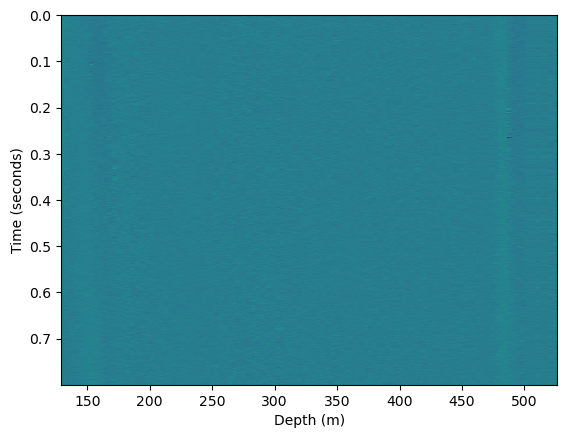

In [1]:
# -*- coding: utf-8 -*-
"""
Copyright (c) 2018 Silixa Ltd
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation
files (the "Software"), to use the Software for the sole purpose of private, non-commercial use and/or in-house company
research and development meaning the right to use, copy, modify, merge, share the Software, and to permit persons to whom
the Software is furnished to like-wise do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
For any intended commercial use then contact the copyright holder, Silixa Ltd, for permission, which shall not be unreasonably
withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR
IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

$Rev:: 26283                                                                  $
$Date:: 2018-03-27 13:14:05 +0100 (Tue, 27 Mar 2018)                          $

Ref:    [1] TDMS_Adv_Read.m
        [2] http://www.ni.com/white-paper/5696/en#toc2

"""

import os, struct, datetime
import pandas as pd
import numpy as np
import mmap

def load_property_map(xls_file):
    prop_map = pd.read_excel(xls_file, sheetname='Sheet1')
    return prop_map[['CurrentTag', 'CorrectTag']].applymap(lambda x: x.replace(" ", "")).set_index('CurrentTag').to_dict()['CorrectTag']

#prop_map = load_property_map('MetaDataTable_iDAS_TDMS_CFG_Tags.xlsx')

def write_property_dict(prop_dict, out_file):
    from pprint import pformat
    f = open(out_file, 'w')
    f.write('tdms_property_map=')
    f.write(pformat(prop_dict))
    f.close()

def type_not_supported(vargin):
    """Function raises a NotImplementedException."""
    raise NotImplementedError("Reading of this tdsDataType is not implemented")


def parse_time_stamp(fractions, seconds):
    """
    Convert time TDMS time representation to datetime
    fractions   -- fractional seconds (2^-64)
    seconds     -- The number of seconds since 1/1/1904
    @rtype : datetime.datetime
    """
    if fractions is not None and seconds is not None and fractions + seconds > 0:
        return datetime.timedelta(0, fractions * 2 ** -64 + seconds) + \
               datetime.datetime(1904, 1, 1)
    else:
        return None


# Enum mapping TDM data types to description string, numpy type where exists
# See Ref[2] for enum values
TDS_DATA_TYPE = dict({
    0x00: 'void', # tdsTypeVoid
    0x01: 'int8', # tdsTypeI8
    0x02: 'int16', # tdsTypeI16
    0x03: 'int32', # tdsTypeI32
    0x04: 'int64', # tdsTypeI64
    0x05: 'uint8', # tdsTypeU8
    0x06: 'uint16', # tdsTypeU16
    0x07: 'uint32', # tdsTypeU32
    0x08: 'uint64', # tdsTypeU64
    0x09: 'float32', # tdsTypeSingleFloat
    0x0a: 'float64', # tdsTypeDoubleFloat
    0x0b: 'float128', # tdsTypeExtendedFloat
    0x19: 'singleFloatWithUnit', # tdsTypeSingleFloatWithUnit
    0x1a: 'doubleFloatWithUnit', # tdsTypeDoubleFloatWithUnit
    0x1b: 'extendedFloatWithUnit', # tdsTypeExtendedFloatWithUnit
    0x20: 'str', # tdsTypeString
    0x21: 'bool', # tdsTypeBoolean
    0x44: 'datetime', # tdsTypeTimeStamp
    0xFFFFFFFF: 'raw'               # tdsTypeDAQmxRawData
})

# Function mapping for reading TDMS data types
TDS_READ_VAL = dict({
    'void': lambda f: None, # tdsTypeVoid
    'int8': lambda f: struct.unpack('<b', f.read(1))[0],
    'int16': lambda f: struct.unpack('<h', f.read(2))[0],
    'int32': lambda f: struct.unpack('<i', f.read(4))[0],
    'int64': lambda f: struct.unpack('<q', f.read(8))[0],
    'uint8': lambda f: struct.unpack('<B', f.read(1))[0],
    'uint16': lambda f: struct.unpack('<H', f.read(2))[0],
    'uint32': lambda f: struct.unpack('<I', f.read(4))[0],
    'uint64': lambda f: struct.unpack('<Q', f.read(8))[0],
    'float32': lambda f: struct.unpack('<f', f.read(4))[0],
    'float64': lambda f: struct.unpack('<d', f.read(8))[0],
    'float128': type_not_supported,
    'singleFloatWithUnit': type_not_supported,
    'doubleFloatWithUnit': type_not_supported,
    'extendedFloatWithUnit': type_not_supported,
    'str': lambda f: f.read(struct.unpack('<i', f.read(4))[0]),
    'bool': lambda f: struct.unpack('<?', f.read(1))[0],
    'datetime': lambda f: parse_time_stamp(
        struct.unpack('<Q', f.read(8))[0], struct.unpack('<q', f.read(8))[0]),
    'raw': type_not_supported
})

DECIMATE_MASK = 0b00100000
LEAD_IN_LENGTH = 28
FILEINFO_NAMES = ('file_tag',
                  'toc',
                  'version',
                  'next_segment_offset',
                  'raw_data_offset')


class TdmsReader(object):
    """A TDMS file reader object for reading properties and data"""

    def __init__(self, filename):
        self._properties = None
        self._end_of_properties_offset = None
        self._data_type = None
        self._chunk_size = None

        self._raw_data = None
        self._raw_data2 = None # The mapped data in the 'Next Segment'
        self._raw_last_chunk = None
        self._raw2_last_chunk = None

        self.file_size = os.path.getsize(filename)
        self._channel_length = None
        self._seg1_length = None
        self._seg2_length = None

        #TODO: Error if file not big enough to hold header
        self._tdms_file = open(filename, 'rb')
        # Read lead in (28 bytes):
        lead_in = self._tdms_file.read(LEAD_IN_LENGTH)
        # lead_in is 28 bytes:
        # [string of length 4][int32][int32][int64][int64]
        fields = struct.unpack('<4siiQQ', lead_in)

        #TODO: validate file
        if fields[0].decode() not in 'TDSm':
            msg = "Not a TDMS file (TDSm tag not found)"
            raise(TypeError, msg)

        self.fileinfo = dict(zip(FILEINFO_NAMES, fields))
        self.fileinfo['decimated'] = not bool(self.fileinfo['toc'] &
                                              DECIMATE_MASK)
        # Make offsets relative to beginning of file:
        self.fileinfo['next_segment_offset'] += LEAD_IN_LENGTH
        self.fileinfo['raw_data_offset'] += LEAD_IN_LENGTH
        self.fileinfo['file_size'] = os.path.getsize(self._tdms_file.name)

        #TODO: Validate lead in:
        if self.fileinfo['next_segment_offset'] > self.file_size:
            self.fileinfo['next_segment_offset'] = self.file_size
            # raise(ValueError, "Next Segment Offset too large in TDMS header")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self._tdms_file.close()

    def _get_channel_length(self):
        if not self._channel_length:
            self._initialise_data()

        return self._channel_length

    channel_length = property(_get_channel_length)

    def get_properties(self, mapped=False):
        """
        Return a dictionary of properties. Read from file only if necessary.
        """
        # Check if already hold properties in memory
        if self._properties is None:
            self._properties = self._read_properties()
        if mapped:
            props = self._properties.copy()
            tmp = [prop_map.get(col.replace(" ", ""),col.replace(" ", "")) for col in self._properties.index]
            tmp1 = []
            def addToList(ls, val, cnt=0):
                if val not in ls:
                    ls.append(val)
                else:
                    newVal = val + '_' + str(cnt+1)
                    if newVal not in ls:
                        ls.append(newVal)
                    else:
                        addToList(ls, val, cnt+1)

            for col in tmp:
                addToList(tmp1, col)

            props.index = tmp1
            return props.loc[:,'Value'].to_dict()
        else:
            return self._properties.loc[:,'Value'].to_dict()

    def _read_property(self):
        """
        Read a single property from the TDMS file.
        Return the name, type and value of the property as a list.
        """
        # Read length of object path:
        var = struct.unpack('<i', self._tdms_file.read(4))[0]
        # Read property name and type:
        name, data_type = struct.unpack('<{0}si'.format(var),
                                        self._tdms_file.read(var + 4))
        # Lookup function to read and parse property value based on type:
        value = TDS_READ_VAL[TDS_DATA_TYPE[data_type]](self._tdms_file)
        name = name.decode()
        if data_type == 32:
            value = value.decode()

        return name, data_type, value

    def _read_properties(self):
        """Read the properties from the file"""
        self._tdms_file.seek(LEAD_IN_LENGTH, 0)
        # Number of channels is total objects - file objects - group objects
        self.fileinfo['n_channels'] = struct.unpack('i',
                                                    self._tdms_file.read(4))[0] - 2
        # Read length of object path:
        var = struct.unpack('<i', self._tdms_file.read(4))[0]
        # skip over object path and raw data index:
        self._tdms_file.seek(var + 4, 1)
        # Read number of properties in this group:
        var = struct.unpack('<i', self._tdms_file.read(4))[0]

        # loop through and read each property
        properties = [self._read_property() for _ in range(var)]
        df = pd.DataFrame(properties)
        df.columns = ['Property', 'Type', 'Value']
        df.set_index('Property', inplace=True)

        self._end_of_properties_offset = self._tdms_file.tell()

        self._read_chunk_size()
        #TODO: Add number of channels to properties
        return df

    def _read_chunk_size(self):
        """ Read the data chunk size from the TDMS file header."""
        if self._end_of_properties_offset is None:
            self._read_properties()

        self._tdms_file.seek(self._end_of_properties_offset, 0)

        # skip over Group Information:
        var = struct.unpack('<i', self._tdms_file.read(4))[0]
        self._tdms_file.seek(var + 8, 1)

        # skip over first channel path and length of index information:
        var = struct.unpack('<i', self._tdms_file.read(4))[0]
        self._tdms_file.seek(var + 4, 1)

        self._data_type = TDS_DATA_TYPE.get(
            struct.unpack('<i', self._tdms_file.read(4))[0])
        if self._data_type not in ('int16', 'float32'):
            raise Exception('Unsupported TDMS data type: ' + self._data_type)

        # Read Dimension of the raw data array (has to be 1):
        dummy = struct.unpack('<i', self._tdms_file.read(4))[0]

        self._chunk_size = struct.unpack('<i', self._tdms_file.read(4))[0]

    def get_data(self, first_ch=0, last_ch=None, first_s=0, last_s=None):
        """
        Get a block of data from the TDMS file.
        first_ch -- The first channel to load
        last_ch  -- The last channel to load
        first_s  -- The first sample to load
        last_s   -- The last sample to load
        """
        if self._raw_data is None:
            self._initialise_data()
        if first_ch is None or first_ch < 0:
            first_ch = 0
        if last_ch is None or last_ch >= self.fileinfo['n_channels']:
            last_ch = self.fileinfo['n_channels']
        else:
            # return data inclusive of last_ch, numpy indexing is exclusive of end index
            last_ch += 1
        if last_s is None or last_s > self._channel_length:
            last_s = self._channel_length
        else:
            # return data inclusive of last_s, numpy indexing is exclusive of end index
            last_s += 1
        nch = int(max(last_ch - first_ch, 0))
        ns = int(max(last_s - first_s, 0))

        # Allocate output container
        data = np.empty((ns, nch), dtype=np.dtype(self._data_type))
        if data.size is 0:
            return data

        ## 1. Index first block & reshape?
        first_blk = first_s // self._chunk_size
        last_blk = last_s // self._chunk_size
        last_full_blk = min(last_blk + 1, self._raw_data.shape[1])
        nchunk = min(max(last_full_blk - first_blk, 0), self._raw_data.shape[1])
        first_s_1a = max(first_s - first_blk * self._chunk_size, 0)
        last_s_1a = min(last_s - first_blk * self._chunk_size, nchunk*self._chunk_size)
        ind_s = 0
        ind_e = ind_s + max(last_s_1a - first_s_1a, 0)

        # data_1a = self._raw_data[:, first_blk:last_full_blk,
        #             first_ch:last_ch].reshape((self._chunk_size*nchunk, nch), order='F')[first_s_1a:last_s_1a, :]
        d = self._raw_data[:, first_blk:last_full_blk,
                    first_ch:last_ch]
        d.shape = (self._chunk_size*nchunk, nch)
        d.reshape((self._chunk_size*nchunk, nch), order='F')
        data[ind_s:ind_e,:] = d[first_s_1a:last_s_1a, :]

        ## 2. Index first additional samples
        first_s_1b = max(first_s - self._raw_data.shape[1]*self._chunk_size, 0)
        last_s_1b = min(last_s - self._raw_data.shape[1]*self._chunk_size, self._raw_last_chunk.shape[0])
        ind_s = ind_e
        ind_e = ind_s + max(last_s_1b - first_s_1b, 0)
        # data_1b = self._raw_last_chunk[first_s_1b:last_s_1b,first_ch:last_ch]
        if ind_e > ind_s:
            data[ind_s:ind_e,:] = self._raw_last_chunk[first_s_1b:last_s_1b,first_ch:last_ch]

        ## 3. Index second block
        first_s_2 = max(first_s - self._seg1_length, 0)
        last_s_2 = last_s - self._seg1_length
        if (first_s_2 > 0 or last_s_2 > 0) and self._raw_data2 is not None:
            first_blk_2 = max(first_s_2 // self._chunk_size, 0)
            last_blk_2 = max(last_s_2 // self._chunk_size, 0)
            last_full_blk_2 = min(last_blk_2 + 1, self._raw_data2.shape[1])
            nchunk_2 = min(max(last_full_blk_2 - first_blk_2, 0), self._raw_data2.shape[1])
            first_s_2a = max(first_s_2 - first_blk_2 * self._chunk_size, 0)
            last_s_2a = min(last_s_2 - first_blk_2 * self._chunk_size, nchunk_2*self._chunk_size)
            ind_s = ind_e
            ind_e = ind_s + max(last_s_2a - first_s_2a, 0)
            # data_2a = self._raw_data2[:, first_blk_2:last_full_blk_2,
            #             first_ch:last_ch].reshape((self._chunk_size*nchunk_2, nch), order='F')[first_s_2a:last_s_2a, :]
            if ind_e > ind_s:
                data[ind_s:ind_e,:] = self._raw_data2[:, first_blk_2:last_full_blk_2,
                        first_ch:last_ch].reshape((self._chunk_size*nchunk_2, nch), order='F')[first_s_2a:last_s_2a, :]
        ## 4. Index second additional samples
        if (first_s_2 > 0 or last_s_2 > 0) and self._raw2_last_chunk is not None:
            first_s_2b = max(first_s_2 - self._raw_data2.shape[1]*self._chunk_size, 0)
            last_s_2b = min(last_s_2 - self._raw_data2.shape[1]*self._chunk_size, self._raw2_last_chunk.shape[0])
            ind_s = ind_e
            ind_e = ind_s + max(last_s_2b - first_s_2b, 0)
            # data_2b = self._raw2_last_chunk[first_s_2b:last_s_2b,first_ch:last_ch]
            if ind_e > ind_s:
                data[ind_s:ind_e,:] = self._raw2_last_chunk[first_s_2b:last_s_2b,first_ch:last_ch]
        ## 5. Concatenate blocks
        # data = np.concatenate((data_1a, data_1b, data_2a, data_2b))
        if data.size == 0:
            data = data.reshape(0,0)
        return data

    def _initialise_data(self):
        """Initialise the memory map for the data array."""
        if self._chunk_size is None:
            self._read_chunk_size()

        dmap = mmap.mmap(self._tdms_file.fileno(), 0, access=mmap.ACCESS_READ)
        rdo = int(self.fileinfo['raw_data_offset'])
        nch = int(self.fileinfo['n_channels'])

        #TODO: Support streaming file type?
        #TODO: Is this a valid calculation for ChannelLength?
        nso = self.fileinfo['next_segment_offset']
        self._seg1_length = int((nso - rdo) / nch / np.dtype(self._data_type).itemsize)
        self._channel_length = self._seg1_length

        if self.fileinfo['decimated']:
            n_complete_blk = int(self._seg1_length / self._chunk_size)
            ax_ord = 'C'
        else:
            n_complete_blk = 0
            ax_ord = 'F'
        self._raw_data = np.ndarray((n_complete_blk, nch, self._chunk_size),
                                    dtype=self._data_type,
                                    buffer=dmap,
                                    offset=rdo)
        # Rotate the axes to [chunk_size, nblk, nch]
        self._raw_data = np.rollaxis(self._raw_data, 2)
        additional_samples = int(self._seg1_length - n_complete_blk * self._chunk_size)
        additional_samples_offset = rdo + n_complete_blk*nch*self._chunk_size*np.dtype(self._data_type).itemsize
        self._raw_last_chunk = np.ndarray((nch, additional_samples),
                                    dtype=self._data_type,
                                    buffer=dmap,
                                    offset=additional_samples_offset,
                                    order=ax_ord)
        # Rotate the axes to [samples, nch]
        self._raw_last_chunk = np.rollaxis(self._raw_last_chunk, 1)

        if self.file_size == nso:
            self._seg2_length = 0
        else:
            self._tdms_file.seek(nso + 12, 0)
            (seg2_nso, seg2_rdo) = struct.unpack('<qq',
                                                 self._tdms_file.read(2 * 8))
            self._seg2_length = (seg2_nso - seg2_rdo) / nch / np.dtype(self._data_type).itemsize
            if self.fileinfo['decimated']:
                n_complete_blk2 = int(self._seg2_length / self._chunk_size)
            else:
                n_complete_blk2 = int(0)
            self._raw_data2 = np.ndarray((n_complete_blk2, nch, self._chunk_size),
                                         dtype=self._data_type,
                                         buffer=dmap,
                                         offset=(nso + LEAD_IN_LENGTH + seg2_rdo))
            self._raw_data2 = np.rollaxis(self._raw_data2, 2)
            additional_samples = int(self._seg2_length - n_complete_blk2 * self._chunk_size)
            additional_samples_offset = nso + LEAD_IN_LENGTH + seg2_rdo + n_complete_blk2*nch*self._chunk_size*np.dtype(self._data_type).itemsize
            self._raw2_last_chunk = np.ndarray((nch, additional_samples),
                                    dtype=self._data_type,
                                    buffer=dmap,
                                    offset=additional_samples_offset,
                                    order=ax_ord)
            # Rotate the axes to [samples, nch]
            self._raw2_last_chunk = np.rollaxis(self._raw2_last_chunk, 1)

            if self._raw_data2.size != 0 or self._raw2_last_chunk.size != 0:
                pass
                # raise Exception('Second segment contains some data, \
                #                 not currently supported')
            self._channel_length = self._seg1_length + self._seg2_length
        # else:
        #     print "Not decimated"
        #     raise Exception('Reading file with decimated flag not set is not \
        #                     supported yet')


if __name__ == '__main__':
    print("TDMS Reader demo.")

    file_path = 'DATA/laach_UTC_20210701_081801.178.tdms'

    print('File: {0}'.format(file_path))

    tdms = TdmsReader(file_path)

    props = tdms.get_properties()

    zero_offset = props.get('Zero Offset (m)')
    channel_spacing = props.get('SpatialResolution[m]') * props.get('Fibre Length Multiplier')
    n_channels = tdms.fileinfo['n_channels']
    depth = zero_offset + np.arange(n_channels) * channel_spacing
    fs = props.get('SamplingFrequency[Hz]')

    print('Number of channels in file: {0}'.format(n_channels))
    print('Time samples in file: {0}'.format(tdms.channel_length))
    print('Sampling frequency (Hz): {0}'.format(fs))

    first_channel = 250
    last_channel = 639
    first_time_sample = 0
    last_time_sample = 3999 # modifier jusqu'au dernier sample ( echattilon)


    some_data = tdms.get_data(first_channel, last_channel, first_time_sample, last_time_sample)
    print('Size of data loaded: {0}'.format(some_data.shape))

    import matplotlib.pyplot as plt

    fig1 = plt.figure()
    img1 = plt.imshow(some_data, aspect='auto', interpolation='none', extent=(depth[first_channel],depth[last_channel], last_time_sample/fs, first_time_sample/fs))
    plt.ylabel('Time (seconds)')
    plt.xlabel('Depth (m)')
    plt.show(block=False)


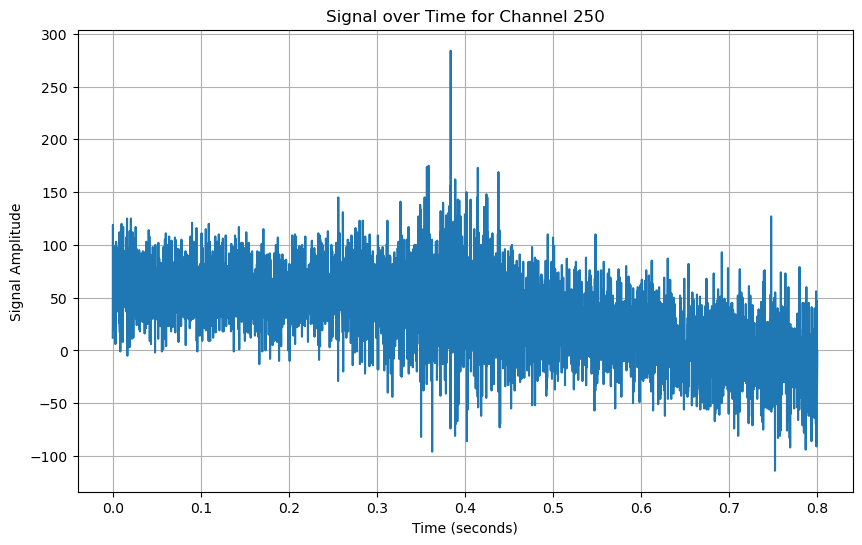

In [2]:
channel_data = some_data[:, 250 - first_channel]
time_array = np.arange(0, 4000) / 5000.0
plt.figure(figsize=(10, 6))
plt.plot(time_array, channel_data)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Amplitude')
plt.title('Signal over Time for Channel 250')
plt.grid(True)
plt.show()


In [3]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

from scatseisnet import ScatteringNetwork

%config InlineBackend.figure_format = "svg"

# parameter

In [59]:
segment_duration_seconds = 20.0
sampling_rate_hertz = 50.0
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)
bank_keyword_arguments = (
    {"octaves": 4, "resolution": 4, "quality": 1},
    {"octaves": 5, "resolution": 2, "quality": 3},
)


# Créer un réseau de diffusion
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)

print(network)

ScatteringNetwork(bins=1000, sampling_rate=50.0, len=2)
ComplexMorletBank(bins=1000, octaves=4, resolution=4, quality=1, sampling_rate=50.0, len=16)
ComplexMorletBank(bins=1000, octaves=5, resolution=2, quality=3, sampling_rate=50.0, len=10)


In [37]:
print(samples_per_segment)

1000


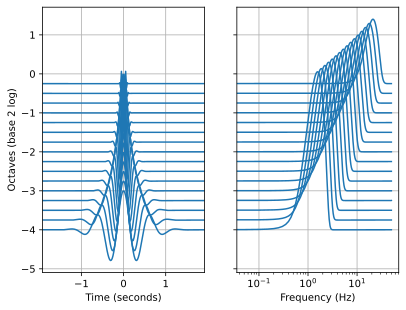

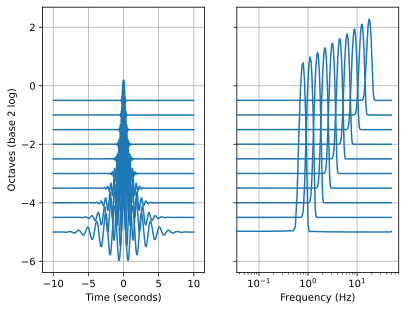

In [5]:
dirpath_save = "network"

# Create directory to save the results
os.makedirs(dirpath_save, exist_ok=True)

# Save the scattering network with Pickle
filepath_save = os.path.join(dirpath_save, "scattering_network.pickle")
with open(filepath_save, "wb") as file_save:
    pickle.dump(network, file_save, protocol=pickle.HIGHEST_PROTOCOL)


 #Loop over network layers
for bank in network.banks:

    # Create axes (left for temporal, right for spectral domain)
    fig, ax = plt.subplots(1, 2, sharey=True)

    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets, bank.spectra, bank.ratios
    ):

        # Time domain
        ax[0].plot(bank.times, wavelet.real + ratio, "C0")

        # Spectral domain (log of amplitude)
        ax[1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of largest wavelet
    width_max = 3 * bank.widths.max()

    # Labels
    ax[0].set_ylabel("Octaves (base 2 log)")
    ax[0].set_xlabel("Time (seconds)")
    ax[0].set_xlim(-width_max, width_max)
    ax[0].grid()
    ax[1].set_xscale("log")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].grid()


In [6]:
# Assumons que vous êtes déjà dans la boucle des wavelets
mother_wavelet_freq = None
for wavelet, spectrum, ratio in zip(bank.wavelets, bank.spectra, bank.ratios):
    # Si c'est la première wavelet (wavelet mère), trouvez la fréquence centrale
    if mother_wavelet_freq is None:
        mother_wavelet_freq = bank.frequencies[np.argmax(np.abs(spectrum))]
        print("Fréquence centrale de la wavelet mère:", mother_wavelet_freq, "Hz")


Fréquence centrale de la wavelet mère: 17.71771771771772 Hz


File: DATA/laach_UTC_20210701_081801.178.tdms


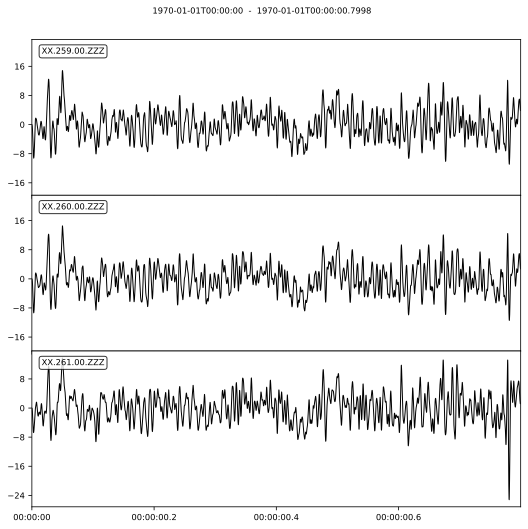

In [145]:
# Pre-processing
import numpy as np
from obspy import Stream, Trace

# Votre code pour lire le fichier .tdms
#print("TDMS Reader demo.")
#file_path = 'laach_UTC_20210701_081801.178.tdms'
print('File: {0}'.format(file_path))

# Initialiser un Stream vide pour ObsPy
stream = Stream()

# Parcourir chaque canal et traiter les données
for channel in range(first_channel, last_channel + 1):
    data = tdms.get_data(channel, channel, first_time_sample, last_time_sample)
    # Aplatir les données en un tableau 1D
    data = data.flatten()
    # Sous-échantillonner les données
   # downsampled_data = data[::10]
    
    # Créer les métadonnées pour le fichier MiniSEED
    stats = {
        'network': 'XX',
        'station': str(channel),
        'location': '00',
        'channel': 'ZZZ',
        'npts': len(data),
        'sampling_rate': fs,  # fs/10
        'mseed': {'dataquality': 'D'}
    }
    
    # Ajouter les données sous-échantillonnées au Stream
    stream += Trace(data=data, header=stats)

# Traitement et visualisation des données
stream.merge(method=1)
stream.detrend("linear")
# stream.filter('bandpass', freqmin=5, freqmax=200) bubbles we want 
#stream.filter(type="highpass", freq=1.0)
stream.filter('bandpass', freqmin=5, freqmax=200)
# Tracez les canaux 10, 11, et 12
stream[9:12].plot(rasterized=True)

# Écriture du Stream au format MiniSEED
stream.write("scattering_stream.mseed", format="MSEED")


In [146]:
print(stream)
#D'après ces informations, il y a 
#390 traces dans le stream,
#ce qui signifie qu'il y a
#390 canaux différents. Ces canaux vont de XX.250.00.ZZZ à XX.639.00.ZZZ.

390 Trace(s) in Stream:

XX.250.00.ZZZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.799800Z | 5000.0 Hz, 4000 samples
...
(388 other traces)
...
XX.639.00.ZZZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.799800Z | 5000.0 Hz, 4000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [155]:
for s in segments:
    print(s.shape)

print(samples_per_segment)

1000


In [237]:
segments = []
timestamps = []
for trace in stream:
    start = 0
    end = samples_per_segment
    while end <= len(trace.data):
        segment = trace.data[start:end]
        # Utilisez le temps de début de la trace actuelle pour le timestamp
        timestamps.append(trace.stats.starttime + start / trace.stats.sampling_rate)
        segments.append(segment)
        start = end
        end += samples_per_segment

# Vérifiez la forme des segments
#for s in segments:
    #print(s.shape)


In [195]:
print(len(timestamps))
#print(timestamps)



1560


In [188]:
scattering_coefficients = network.transform(segments, reduce_type=np.max)
#print(scattering_coefficients)


In [191]:
print(scattering_coefficients[0].shape)
#La forme (1560, 16) indique que vous avez 1560 segments (ou échantillons) 
#et que chaque segment a 16 coefficients de diffusion pour le premier ordre.

(1560, 16)


La première courbe (en haut) : C'est la forme d'onde de la trace sismique pour un canal spécifique (dans votre cas, c'est le canal 0). C'est essentiellement l'amplitude du signal sismique en fonction du temps. Cette forme d'onde représente les vibrations du sol enregistrées par le capteur ou le canal spécifique au fil du temps.

La deuxième courbe (en bas) : C'est une visualisation des coefficients de diffusion pour le même canal. Les coefficients de diffusion sont calculés en utilisant la transformée en ondelettes, et ils capturent certaines caractéristiques ou "textures" du signal original à différentes échelles ou fréquences. Sur l'axe vertical, vous avez les fréquences (ou échelles) de la transformée en ondelettes. Sur l'axe horizontal, vous avez le temps. La couleur de chaque pixel représente la valeur du coefficient de diffusion à une fréquence et un temps spécifiques.

En résumé :

La première courbe montre l'amplitude du signal sismique original en fonction du temps.
La deuxième courbe montre les caractéristiques ou "textures" du signal sismique à différentes fréquences et moments dans le temps.





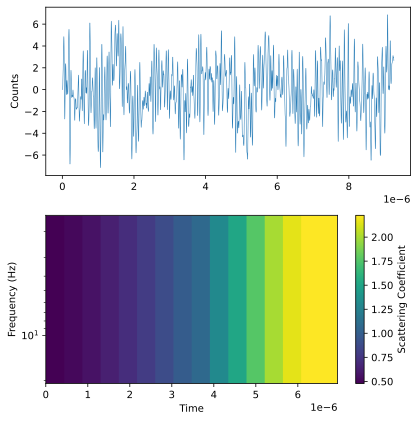

In [199]:
# Extract the first channel
channel_id = 250  # Adjust this to select the desired channel

# Assuming one scattering coefficient per channel in your setup
order_1 = np.log10(scattering_coefficients[0][channel_id, :])

center_frequencies = network.banks[0].centers

# Get the corresponding trace from the stream
trace = stream[channel_id]

# Create figure and axes
fig, ax = plt.subplots(2, dpi=300, figsize=(6, 6))

# Plot the waveform
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# Display the scattering coefficients using imshow
# Since order_1 is 1D, we need to expand its dimensions
order_1_2d = order_1[np.newaxis, :]

im = ax[1].imshow(order_1_2d, aspect='auto', cmap='viridis', origin='lower',
                  extent=[mdates.date2num(timestamps[0]), mdates.date2num(timestamps[-1]), center_frequencies[0], center_frequencies[-1]])

# Axes labels
ax[1].set_yscale("log")
ax[1].set_xlabel("Time")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")
fig.colorbar(im, ax=ax[1], label="Scattering Coefficient")

# Show
plt.tight_layout()
plt.show()


In [200]:
# Sauvegarder tous les coefficients de diffusion et les horodatages
np.savez(
    "scattering_coefficients.npz",
    order_1=scattering_coefficients[0],  # Ceci sauvegarde tous les 16 coefficients pour le premier ordre
    order_2=scattering_coefficients[1],  # Ceci sauvegarde tous les coefficients pour le second ordre (si ils existent)
    times=timestamps
)


In [235]:
# Chargement des données depuis le fichier fourni
with np.load("scattering_coefficients.npz", allow_pickle=True) as data:
    order_1_loaded = data["order_1"]
    order_2_loaded = data["order_2"]
    times_loaded = data["times"]

order_1_loaded.shape, order_2_loaded.shape, times_loaded.shape


((1560, 16), (1560, 16, 10), (1560,))

## Dimensionality reduction

In [202]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA

plt.rcParams["date.converter"] = "concise"
%config InlineBackend.figure_format = "svg"

# Load data from file
with np.load("scattering_coefficients.npz", allow_pickle=True) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 1560 samples of 176 dimensions each.


## À l'origine :

Vous aviez un fichier avec 640 canaux.
Chaque canal contenait 100 000 échantillons temporels.
Vous avez chargé une partie des données, avec une taille de (4000, 390), ce qui signifie que vous avez 4000 échantillons temporels pour 390 cana## ux.
Après la transformation de diffusion :

Vous avez transformé ces données en coefficients de diffusion.
Vous avez obtenu 1560 échantillons (ou segments) avec des coefficients de diffusion pour chaque segment.
Chaque échantillon a maintenant un vecteur de 176 dimensions caractérisant ce segment en termes de coefficients de diffusion.
Oui, c'est une forme de réduction dimensionnelle. Au lieu d'avoir les valeurs brutes du signal pour chaque canal à chaque échantillon temporel, vous avez maintenant des coefficients qui caractérisent le contenu en fréquence et la structure du signal pour des segments de signal plu## s longs.

Les coefficients 
e diffusion sont conçus pour capturer des caractéristiques importantes du signal original tout en réduisant la dimensionnalité des données. Cela peut rendre les données plus gérables et souvent plus utiles pour des tâches comme la classification ou la reconnaissance de motifs, car les coefficients de diffusion peuvent capturer des caractéristiques essentielles du signal tout en ignorant le bruit ou d'autres informations non essentielles.







## Extract independant features

In [204]:
model = FastICA(n_components=10, whiten="unit-variance", random_state=42)
features = model.fit_transform(scattering_coefficients)

In [205]:
# Save the features
np.savez(
    "independent_components.npz",
    features=features,
    times=times,
)

# Save the dimension reduction model
with open("dimension_model.pickle", "wb") as pickle_file:
    pickle.dump(
        model,
        pickle_file,
        protocol=pickle.HIGHEST_PROTOCOL,
    )

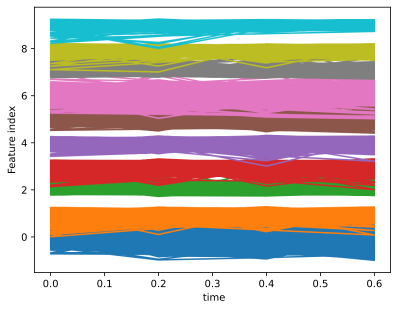

In [208]:
# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=200)
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel(" time")

# Show
plt.show()

#Les différentes couleurs que vous voyez correspondent à différentes caractéristiques 
#(ou dimensions) de vos données. Chaque ligne (ou couleur) 
#"représente une caractéristique différente au fil du temps.

## Load the data

In [209]:
# Load the scattering network
network = pickle.load(open("network/scattering_network.pickle", "rb"))

# Load the dimensionality reduction model
dimension_model = pickle.load(open("dimension_model.pickle", "rb"))

# Load data from file
with np.load("independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

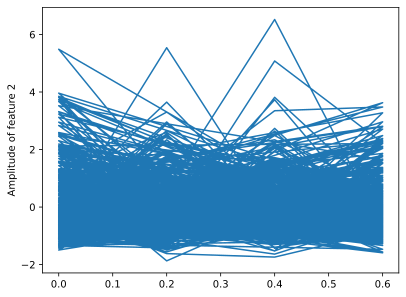

In [218]:
# Pick a feature
feature_id = 2
feature = features[:, feature_id]

# Figure creation
fig = plt.figure()
ax = plt.axes()

# Plot the weights
ax.plot(times, feature)
ax.set_ylabel(f"Amplitude of feature {feature_id}")

# Show
plt.show()

In [221]:
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
n_order_2 = network.banks[1].octaves * network.banks[1].resolution
n_order_1


16

In [232]:
weights = dimension_model.components_[feature_id]
len(weights)


176

In [233]:
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)
len(order_1)


3

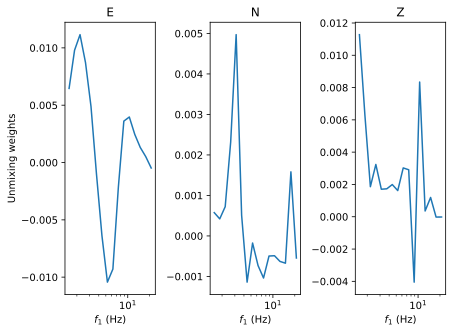

In [239]:
# Etract weights from the dimensionality reduction model
weights = dimension_model.components_[feature_id]
vmax = np.abs(weights).max()

# Scattering coefficients shape and frequencies
n_cha = 3
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
f_1 = network.banks[0].centers

# Extract and reshape weights
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)

# Show weights
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True)  # Modify number of rows to 1
for id, channel in enumerate("ENZ"):
    ax[id].plot(f_1, order_1[id], label=channel)
    ax[id].set_title(channel)
    ax[id].set_xlabel("$f_1$ (Hz)")

# Labels
ax[0].set_ylabel("Unmixing weights")
ax[0].set_xscale("log")

plt.tight_layout()
plt.show()


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_6232\1221533328.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mappable = ax[id].pcolormesh(times_float, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)


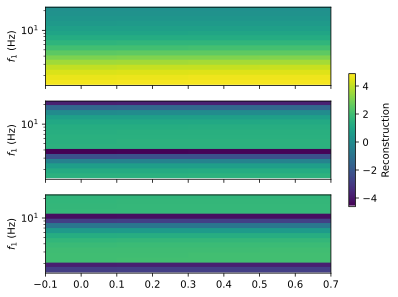

In [245]:
# Filter out latent space
features_filtered = np.zeros(features.shape)
features_filtered[:, feature_id] = feature

# Extract all scattering coefficients
reconstructed = dimension_model.inverse_transform(features_filtered)
reconstructed_order_1 = reconstructed[:, : n_cha * n_order_1].reshape(-1, n_cha, n_order_1)

# Check for object type and convert to float64 if necessary
if reconstructed_order_1.dtype == 'O':
    reconstructed_order_1 = reconstructed_order_1.astype(np.float64)

vmin = reconstructed_order_1.min()
vmax = reconstructed_order_1.max()
times_float = times.astype(np.float64)

# Plot
fig, ax = plt.subplots(nrows=3, sharex=True, sharey="row")

# Plot
for id, channel in enumerate("ENZ"):
    data = reconstructed_order_1[:, id, :].squeeze().T
    mappable = ax[id].pcolormesh(times_float, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)
    ax[id].set_ylabel("$f_1$ (Hz)")
    ax[id].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="vertical", ax=ax, shrink=0.5)
colorbar.set_label("Reconstruction")  # Modifié "Scattering coefficients" à "Reconstruction"


## Clustering

In [303]:
# Load features and datetimes from file
with np.load("independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

# Load network
network = pickle.load(open("network/scattering_network.pickle", "rb"))

In [304]:
print("Shape of times:", times.shape)



Shape of times: (1560,)


In [305]:
N_CLUSTERS = 10
from sklearn.cluster import KMeans

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, n_init="auto", random_state=4)
model.fit(features)

# Predict cluster for each sample
predictions = model.predict(features)

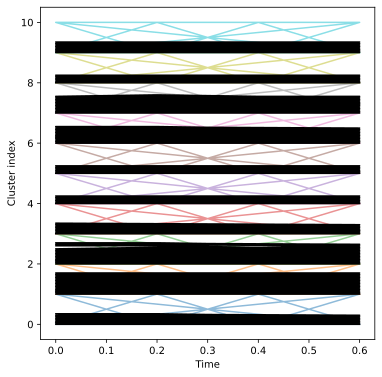

In [306]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")

plt.show()


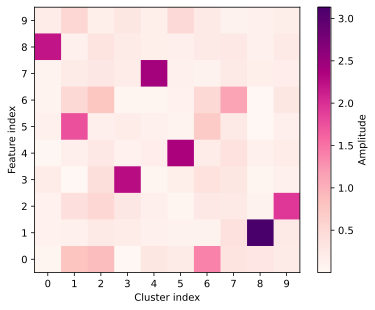

In [307]:
centroids = np.abs(model.cluster_centers_)

# Plot the centroids
fig = plt.figure()
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="RdPu")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Ticks below
ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(centroids.shape[1]))
ax.invert_yaxis()

# Show
plt.show()

In [308]:
N_WAVEFORMS = 5

# Read the stream
stream = obspy.read("scattering_stream.mseed").select(channel="ZZZ")
waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    closest = times[predictions == cluster][distance.argsort()[:5]]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = obspy.UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy()
        traces.append(trace)
    waveforms.append(traces)

In [291]:
#stream = obspy.read("scattering_stream.mseed")
print(trace)

XX.250.00.ZZZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.799800Z | 5000.0 Hz, 4000 samples


In [309]:
print("Shape of times:", times.shape)
print("Shape of predictions:", predictions.shape)
print("Shape of features:", features.shape)


Shape of times: (1560,)
Shape of predictions: (1560,)
Shape of features: (1560, 10)


In [275]:
channels = {tr.stats.channel for tr in stream}
print(channels)


{'ZZZ'}


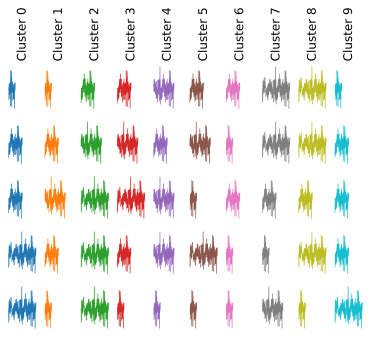

In [310]:
# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=300)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show()

In [311]:
# Print first few values of the first waveform of each cluster
for cluster_id, cluster_waveforms in enumerate(waveforms):
    print(f"Cluster {cluster_id}:")
    if cluster_waveforms:
        print(cluster_waveforms[2].data[:10])
    else:
        print("No waveforms.")


Cluster 0:
[-13.11276932 -12.11950863 -10.92559562  -9.62734114  -8.36114597
  -7.25654546  -6.40397158  -5.8667713   -5.6729869   -5.74264357]
Cluster 1:
[ 4.07158106  3.69129014  3.23697799  2.735053    2.21944691  1.69144857
  1.12421541  0.51369213 -0.11521615 -0.73575728]
Cluster 2:
[-0.01036875 -0.06877867 -0.22778311 -0.5305041  -1.01410824 -1.70984219
 -2.62833245 -3.75073343 -5.02005333 -6.34468318]
Cluster 3:
[-0.01036875 -0.06877867 -0.22778311 -0.5305041  -1.01410824 -1.70984219
 -2.62833245 -3.75073343 -5.02005333 -6.34468318]
Cluster 4:
[ 4.07158106  3.69129014  3.23697799  2.735053    2.21944691  1.69144857
  1.12421541  0.51369213 -0.11521615 -0.73575728]
Cluster 5:
[-0.61629565 -0.73662186 -0.73033584 -0.65468568 -0.5784047  -0.5082641
 -0.39298698 -0.17656855  0.15980607  0.5792155 ]
Cluster 6:
[-13.11276932 -12.11950863 -10.92559562  -9.62734114  -8.36114597
  -7.25654546  -6.40397158  -5.8667713   -5.6729869   -5.74264357]
Cluster 7:
[-13.11276932 -12.11950863 -10.9